In [31]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten, UpSampling2D, LeakyReLU, Dense, Input, add
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Suppress TensorFlow deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [32]:
# Define a residual block for the generator
def res_block(ip):
    # First convolutional layer
    res_model = Conv2D(64, (3, 3), padding="same")(ip)
    res_model = BatchNormalization(momentum=0.5)(res_model)
    res_model = PReLU(shared_axes=[1, 2])(res_model)
    
    # Second convolutional layer
    res_model = Conv2D(64, (3, 3), padding="same")(res_model)
    res_model = BatchNormalization(momentum=0.5)(res_model)
    
    # Skip connection: add input to processed tensor
    return add([ip, res_model])

# Define an upscale block for the generator
def upscale_block(ip):
    # Convolutional layer
    up_model = Conv2D(256, (3, 3), padding="same")(ip)
    # Upsampling
    up_model = UpSampling2D(size=2)(up_model)
    # Activation function
    up_model = PReLU(shared_axes=[1, 2])(up_model)
    
    return up_model


In [33]:
# Generator model creation function
def create_gen(gen_ip, num_res_block):
    # Initial convolutional layer
    layers = Conv2D(64, (9, 9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1, 2])(layers)

    # Store the initial tensor for the skip connection
    temp = layers

    # Add residual blocks
    for i in range(num_res_block):
        layers = res_block(layers)

    # Additional convolutional layer before the skip connection
    layers = Conv2D(64, (3, 3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers, temp])  # Skip connection

    # Upscaling blocks
    layers = upscale_block(layers)
    layers = upscale_block(layers)

    # Final convolutional layer for output
    op = Conv2D(3, (9, 9), padding="same")(layers)  # 3 filters for RGB channels

    # Create and return the generator model
    return Model(inputs=gen_ip, outputs=op)


In [34]:
def discriminator_block(ip, filters, strides=1, bn=True):
    # Convolutional layer
    disc_model = Conv2D(filters, (3, 3), strides=strides, padding="same")(ip)
    
    # Batch normalization
    if bn:
        disc_model = BatchNormalization(momentum=0.8)(disc_model)
    
    # Leaky ReLU activation
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    
    return disc_model

In [35]:
def create_disc(disc_ip):
    # Number of filters
    df = 64
    
    # Stack discriminator blocks
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    # Flatten the feature maps
    d8_5 = Flatten()(d8)
    
    # Fully connected layers
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    
    # Output layer (sigmoid activation for binary classification)
    validity = Dense(1, activation='sigmoid')(d10)

    # Create and return the discriminator model
    return Model(disc_ip, validity)


In [36]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    # Load pre-trained VGG19 model
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)
    
    # Create a new Model that outputs feature maps from the 11th layer of VGG19
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [37]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    # Generate high-resolution image from low-resolution input
    gen_img = gen_model(lr_ip)
    
    # Extract features from the generated high-resolution image
    gen_features = vgg(gen_img)
    
    # Set discriminator model as non-trainable
    disc_model.trainable = False
    
    # Predict the validity (real or fake) of the generated high-resolution image
    validity = disc_model(gen_img)
    
    # Create and return the combined model
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


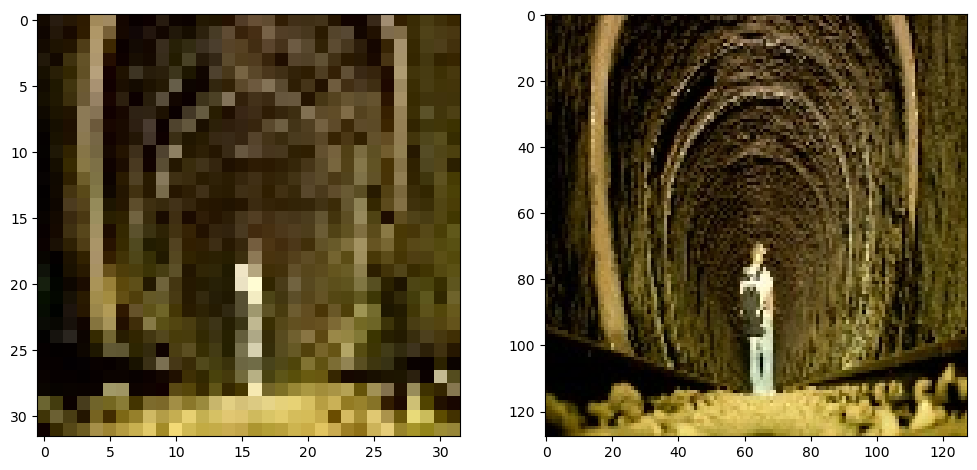

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 32, 32, 64)           15616     ['input_4[0][0]']             
                                                                                                  
 p_re_lu_19 (PReLU)          (None, 32, 32, 64)           64        ['conv2d_45[0][0]']           
                                                                                                  
 conv2d_46 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_19[0][0]']          
                                                                                            

                                                                    ']                            
                                                                                                  
 conv2d_55 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_24[0][0]']          
                                                                                                  
 batch_normalization_49 (Ba  (None, 32, 32, 64)           256       ['conv2d_55[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 add_21 (Add)                (None, 32, 32, 64)           0         ['add_20[0][0]',              
                                                                     'batch_normalization_49[0][0]
                                                                    ']                            
          

                                                                                                  
 p_re_lu_29 (PReLU)          (None, 32, 32, 64)           64        ['batch_normalization_58[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_65 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_29[0][0]']          
                                                                                                  
 batch_normalization_59 (Ba  (None, 32, 32, 64)           256       ['conv2d_65[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 add_26 (Add)                (None, 32, 32, 64)           0         ['add_25[0][0]',              
          

 batch_normalization_68 (Ba  (None, 32, 32, 64)           256       ['conv2d_74[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 p_re_lu_34 (PReLU)          (None, 32, 32, 64)           64        ['batch_normalization_68[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_75 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_34[0][0]']          
                                                                                                  
 batch_normalization_69 (Ba  (None, 32, 32, 64)           256       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                                 
 conv2d_87 (Conv2D)          (None, 16, 16, 256)       590080    
                                                                 
 batch_normalization_77 (Ba  (None, 16, 16, 256)       1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 conv2d_88 (Conv2D)          (None, 16, 16, 512)       1180160   
                                                                 
 batch_normalization_78 (Ba  (None, 16, 16, 512)       2048      
 tchNormalization)                                               
                                                                 
 leaky_re_

In [38]:
#For demo purposes, let us use 5000 images
n=200
lr_list = os.listdir("lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    


In [39]:
epochs = 5

# Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1))  # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size, 1))   # Assign a label of 1 to all real images.
    
    # Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []
    
    # Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b]  # Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b]  # Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs)  # Fake images
        
        # First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        # Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        # Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        # Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        # Train the generator via GAN.
        # Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        # Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    # Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    # Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    # Report the progress during training.
    print("epoch:", e+1, "g_loss:", g_loss, "d_loss:", d_loss)


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 147ms/step


  1%|▌                                                                                 | 1/134 [00:20<44:41, 20.16s/it]

1/1 [==============================] - 0s 61ms/step


  1%|█▏                                                                                | 2/134 [00:21<20:01,  9.10s/it]

1/1 [==============================] - 0s 90ms/step


  2%|█▊                                                                                | 3/134 [00:23<12:17,  5.63s/it]

1/1 [==============================] - 0s 61ms/step


  3%|██▍                                                                               | 4/134 [00:24<08:35,  3.97s/it]

1/1 [==============================] - 0s 61ms/step


  4%|███                                                                               | 5/134 [00:25<06:30,  3.03s/it]

1/1 [==============================] - 0s 75ms/step


  4%|███▋                                                                              | 6/134 [00:27<05:20,  2.50s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:28<04:30,  2.13s/it]

1/1 [==============================] - 0s 61ms/step


  6%|████▉                                                                             | 8/134 [00:30<03:58,  1.89s/it]

1/1 [==============================] - 0s 75ms/step


  7%|█████▌                                                                            | 9/134 [00:31<03:43,  1.79s/it]

1/1 [==============================] - 0s 62ms/step


  7%|██████                                                                           | 10/134 [00:33<03:27,  1.68s/it]

1/1 [==============================] - 0s 61ms/step


  8%|██████▋                                                                          | 11/134 [00:34<03:14,  1.58s/it]

1/1 [==============================] - 0s 67ms/step


  9%|███████▎                                                                         | 12/134 [00:35<03:07,  1.54s/it]

1/1 [==============================] - 0s 61ms/step


 10%|███████▊                                                                         | 13/134 [00:37<02:59,  1.49s/it]

1/1 [==============================] - 0s 61ms/step


 10%|████████▍                                                                        | 14/134 [00:38<02:54,  1.45s/it]

1/1 [==============================] - 0s 65ms/step


 11%|█████████                                                                        | 15/134 [00:39<02:51,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 12%|█████████▋                                                                       | 16/134 [00:41<02:48,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 13%|██████████▎                                                                      | 17/134 [00:42<02:45,  1.42s/it]

1/1 [==============================] - 0s 71ms/step


 13%|██████████▉                                                                      | 18/134 [00:44<02:44,  1.42s/it]

1/1 [==============================] - 0s 77ms/step


 14%|███████████▍                                                                     | 19/134 [00:45<02:44,  1.43s/it]

1/1 [==============================] - 0s 70ms/step


 15%|████████████                                                                     | 20/134 [00:47<02:44,  1.44s/it]

1/1 [==============================] - 0s 70ms/step


 16%|████████████▋                                                                    | 21/134 [00:48<02:44,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 16%|█████████████▎                                                                   | 22/134 [00:50<02:43,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:51<02:38,  1.43s/it]

1/1 [==============================] - 0s 75ms/step


 18%|██████████████▌                                                                  | 24/134 [00:52<02:36,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 19%|███████████████                                                                  | 25/134 [00:54<02:34,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:55<02:31,  1.40s/it]

1/1 [==============================] - 0s 72ms/step


 20%|████████████████▎                                                                | 27/134 [00:57<02:32,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:58<02:29,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 22%|█████████████████▌                                                               | 29/134 [00:59<02:26,  1.40s/it]

1/1 [==============================] - 0s 67ms/step


 22%|██████████████████▏                                                              | 30/134 [01:01<02:27,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▋                                                              | 31/134 [01:02<02:26,  1.42s/it]

1/1 [==============================] - 0s 82ms/step


 24%|███████████████████▎                                                             | 32/134 [01:04<02:26,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


 25%|███████████████████▉                                                             | 33/134 [01:05<02:26,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [01:07<02:23,  1.43s/it]

1/1 [==============================] - 0s 77ms/step


 26%|█████████████████████▏                                                           | 35/134 [01:08<02:23,  1.45s/it]

1/1 [==============================] - 0s 61ms/step


 27%|█████████████████████▊                                                           | 36/134 [01:09<02:20,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 28%|██████████████████████▎                                                          | 37/134 [01:11<02:18,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 28%|██████████████████████▉                                                          | 38/134 [01:12<02:18,  1.45s/it]

1/1 [==============================] - 0s 64ms/step


 29%|███████████████████████▌                                                         | 39/134 [01:14<02:15,  1.42s/it]

1/1 [==============================] - 0s 74ms/step


 30%|████████████████████████▏                                                        | 40/134 [01:15<02:14,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 31%|████████████████████████▊                                                        | 41/134 [01:17<02:12,  1.43s/it]

1/1 [==============================] - 0s 60ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:18<02:09,  1.41s/it]

1/1 [==============================] - 0s 83ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:19<02:10,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:21<02:08,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:22<02:05,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:24<02:05,  1.43s/it]

1/1 [==============================] - 0s 69ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:25<02:04,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:26<02:01,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:28<01:59,  1.40s/it]

1/1 [==============================] - 0s 75ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:29<01:58,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:31<01:56,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:32<01:55,  1.41s/it]

1/1 [==============================] - 0s 92ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:34<01:58,  1.47s/it]

1/1 [==============================] - 0s 70ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:35<01:57,  1.47s/it]

1/1 [==============================] - 0s 68ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:37<01:57,  1.48s/it]

1/1 [==============================] - 0s 73ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:38<01:56,  1.49s/it]

1/1 [==============================] - 0s 68ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:40<01:54,  1.49s/it]

1/1 [==============================] - 0s 69ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:41<01:54,  1.50s/it]

1/1 [==============================] - 0s 82ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:43<01:52,  1.51s/it]

1/1 [==============================] - 0s 68ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:44<01:48,  1.47s/it]

1/1 [==============================] - 0s 61ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:46<01:45,  1.44s/it]

1/1 [==============================] - 0s 96ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:47<01:44,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:48<01:42,  1.44s/it]

1/1 [==============================] - 0s 60ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:50<01:39,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:51<01:37,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:53<01:35,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:54<01:33,  1.40s/it]

1/1 [==============================] - 0s 69ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:55<01:32,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:57<01:31,  1.41s/it]

1/1 [==============================] - 0s 65ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:58<01:29,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [02:00<01:28,  1.41s/it]

1/1 [==============================] - 0s 75ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [02:01<01:29,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [02:03<01:27,  1.44s/it]

1/1 [==============================] - 0s 72ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [02:04<01:25,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [02:05<01:23,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [02:07<01:21,  1.40s/it]

1/1 [==============================] - 0s 66ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [02:08<01:20,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [02:10<01:19,  1.42s/it]

1/1 [==============================] - 0s 60ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [02:11<01:17,  1.40s/it]

1/1 [==============================] - 0s 70ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [02:12<01:16,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [02:14<01:13,  1.39s/it]

1/1 [==============================] - 0s 61ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [02:15<01:11,  1.38s/it]

1/1 [==============================] - 0s 72ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [02:16<01:10,  1.39s/it]

1/1 [==============================] - 0s 61ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:18<01:09,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:19<01:07,  1.38s/it]

1/1 [==============================] - 0s 74ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:21<01:07,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:22<01:07,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:24<01:04,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:25<01:02,  1.40s/it]

1/1 [==============================] - 0s 68ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:26<01:02,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:28<01:00,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:29<00:59,  1.41s/it]

1/1 [==============================] - 0s 73ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:31<00:58,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:32<00:56,  1.40s/it]

1/1 [==============================] - 0s 67ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:33<00:54,  1.39s/it]

1/1 [==============================] - 0s 65ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:35<00:53,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:36<00:52,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:38<00:50,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:39<00:48,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:40<00:47,  1.40s/it]

1/1 [==============================] - 0s 68ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:42<00:46,  1.40s/it]

1/1 [==============================] - 0s 71ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:43<00:45,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:45<00:43,  1.42s/it]

1/1 [==============================] - 0s 69ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:46<00:43,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:48<00:42,  1.48s/it]

1/1 [==============================] - 0s 68ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:49<00:41,  1.47s/it]

1/1 [==============================] - 0s 64ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:51<00:39,  1.46s/it]

1/1 [==============================] - 0s 61ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:52<00:37,  1.43s/it]

1/1 [==============================] - 0s 72ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:53<00:35,  1.42s/it]

1/1 [==============================] - 0s 71ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:55<00:34,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:56<00:32,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:58<00:31,  1.41s/it]

1/1 [==============================] - 0s 72ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:59<00:29,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [03:00<00:28,  1.40s/it]

1/1 [==============================] - 0s 63ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [03:02<00:26,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [03:03<00:25,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [03:05<00:23,  1.39s/it]

1/1 [==============================] - 0s 69ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [03:06<00:22,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [03:07<00:20,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [03:09<00:19,  1.38s/it]

1/1 [==============================] - 0s 61ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [03:10<00:18,  1.39s/it]

1/1 [==============================] - 0s 74ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [03:12<00:16,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [03:13<00:15,  1.40s/it]

1/1 [==============================] - 0s 64ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [03:14<00:14,  1.41s/it]

1/1 [==============================] - 0s 60ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [03:16<00:12,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:17<00:11,  1.39s/it]

1/1 [==============================] - 0s 68ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:19<00:09,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:20<00:08,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:21<00:06,  1.39s/it]

1/1 [==============================] - 0s 92ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:23<00:05,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:24<00:04,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:26<00:02,  1.41s/it]

1/1 [==============================] - 0s 79ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:27<00:01,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:28<00:00,  1.56s/it]


epoch: 1 g_loss: 137.97379163485854 d_loss: [9.40988318 0.61567164]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:00,  1.35s/it]

1/1 [==============================] - 0s 72ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:06,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:02,  1.39s/it]

1/1 [==============================] - 0s 61ms/step


  3%|██▍                                                                               | 4/134 [00:05<02:58,  1.37s/it]

1/1 [==============================] - 0s 73ms/step


  4%|███                                                                               | 5/134 [00:06<02:59,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:58,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:55,  1.38s/it]

1/1 [==============================] - 0s 67ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:56,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:55,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


  7%|██████                                                                           | 10/134 [00:13<02:52,  1.39s/it]

1/1 [==============================] - 0s 78ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 66ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:53,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:51,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:51,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:49,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:46,  1.41s/it]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▎                                                                      | 17/134 [00:23<02:45,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:44,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:40,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:38,  1.39s/it]

1/1 [==============================] - 0s 71ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:39,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:30<02:37,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:36,  1.41s/it]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▌                                                                  | 24/134 [00:33<02:37,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:35,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:32,  1.41s/it]

1/1 [==============================] - 0s 72ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:32,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:28,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 22%|█████████████████▌                                                               | 29/134 [00:40<02:26,  1.39s/it]

1/1 [==============================] - 0s 67ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:26,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 23%|██████████████████▋                                                              | 31/134 [00:43<02:23,  1.39s/it]

1/1 [==============================] - 0s 64ms/step


 24%|███████████████████▎                                                             | 32/134 [00:44<02:20,  1.38s/it]

1/1 [==============================] - 0s 70ms/step


 25%|███████████████████▉                                                             | 33/134 [00:46<02:21,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                            | 34/134 [00:47<02:19,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:18,  1.39s/it]

1/1 [==============================] - 0s 89ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:50<02:23,  1.47s/it]

1/1 [==============================] - 0s 89ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:25,  1.50s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:53<02:21,  1.47s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:21,  1.49s/it]

1/1 [==============================] - 0s 61ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:56<02:16,  1.45s/it]

1/1 [==============================] - 0s 61ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:58<02:13,  1.44s/it]

1/1 [==============================] - 0s 71ms/step


 31%|█████████████████████████▍                                                       | 42/134 [00:59<02:14,  1.46s/it]

1/1 [==============================] - 0s 73ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:00<02:11,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:07,  1.42s/it]

1/1 [==============================] - 0s 70ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:03<02:06,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:05<02:03,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:06<02:02,  1.41s/it]

1/1 [==============================] - 0s 70ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:07<02:02,  1.42s/it]

1/1 [==============================] - 0s 64ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:09<02:00,  1.42s/it]

1/1 [==============================] - 0s 65ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:10<01:59,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:12<01:57,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:13<01:55,  1.40s/it]

1/1 [==============================] - 0s 74ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:15<01:55,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:16<01:52,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:17<01:51,  1.41s/it]

1/1 [==============================] - 0s 76ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:19<01:51,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:20<01:49,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:22<01:47,  1.41s/it]

1/1 [==============================] - 0s 70ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:23<01:46,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:24<01:43,  1.40s/it]

1/1 [==============================] - 0s 69ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:26<01:41,  1.39s/it]

1/1 [==============================] - 0s 72ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:27<01:41,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:29<01:38,  1.39s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:30<01:37,  1.40s/it]

1/1 [==============================] - 0s 68ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:31<01:37,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:33<01:34,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:34<01:34,  1.41s/it]

1/1 [==============================] - 0s 64ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:36<01:33,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:37<01:30,  1.39s/it]

1/1 [==============================] - 0s 67ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:38<01:28,  1.39s/it]

1/1 [==============================] - 0s 75ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:40<01:28,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:41<01:26,  1.39s/it]

1/1 [==============================] - 0s 80ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:43<01:26,  1.42s/it]

1/1 [==============================] - 0s 75ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:44<01:25,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:45<01:22,  1.40s/it]

1/1 [==============================] - 0s 80ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:47<01:21,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:48<01:20,  1.41s/it]

1/1 [==============================] - 0s 64ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:50<01:18,  1.40s/it]

1/1 [==============================] - 0s 77ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:51<01:17,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:52<01:15,  1.40s/it]

1/1 [==============================] - 0s 71ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:54<01:15,  1.43s/it]

1/1 [==============================] - 0s 74ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:56<01:15,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:57<01:14,  1.47s/it]

1/1 [==============================] - 0s 72ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [01:58<01:13,  1.46s/it]

1/1 [==============================] - 0s 66ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:00<01:12,  1.47s/it]

1/1 [==============================] - 0s 61ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:01<01:10,  1.47s/it]

1/1 [==============================] - 0s 67ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:03<01:07,  1.43s/it]

1/1 [==============================] - 0s 75ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:04<01:06,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:06<01:04,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:07<01:01,  1.41s/it]

1/1 [==============================] - 0s 69ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:08<01:01,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:10<00:59,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:11<00:57,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:13<00:56,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:14<00:54,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:15<00:52,  1.39s/it]

1/1 [==============================] - 0s 76ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:17<00:51,  1.40s/it]

1/1 [==============================] - 0s 73ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:18<00:50,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:20<00:48,  1.40s/it]

1/1 [==============================] - 0s 64ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:21<00:47,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:22<00:46,  1.40s/it]

1/1 [==============================] - 0s 64ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:24<00:44,  1.39s/it]

1/1 [==============================] - 0s 61ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:25<00:42,  1.38s/it]

1/1 [==============================] - 0s 74ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:27<00:42,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:28<00:40,  1.39s/it]

1/1 [==============================] - 0s 80ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:29<00:39,  1.39s/it]

1/1 [==============================] - 0s 73ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:31<00:38,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:32<00:36,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:34<00:34,  1.40s/it]

1/1 [==============================] - 0s 64ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:35<00:34,  1.43s/it]

1/1 [==============================] - 0s 64ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:36<00:32,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:38<00:30,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:39<00:30,  1.45s/it]

1/1 [==============================] - 0s 61ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:41<00:29,  1.45s/it]

1/1 [==============================] - 0s 76ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:42<00:27,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:44<00:25,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:45<00:24,  1.41s/it]

1/1 [==============================] - 0s 85ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:46<00:22,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:48<00:21,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:49<00:19,  1.39s/it]

1/1 [==============================] - 0s 75ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:51<00:18,  1.40s/it]

1/1 [==============================] - 0s 72ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:52<00:16,  1.42s/it]

1/1 [==============================] - 0s 77ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:53<00:15,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:55<00:13,  1.39s/it]

1/1 [==============================] - 0s 71ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:56<00:12,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [02:58<00:11,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [02:59<00:09,  1.40s/it]

1/1 [==============================] - 0s 79ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:01<00:08,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:02<00:07,  1.40s/it]

1/1 [==============================] - 0s 61ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:03<00:05,  1.39s/it]

1/1 [==============================] - 0s 85ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:05<00:04,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:06<00:02,  1.41s/it]

1/1 [==============================] - 0s 69ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:07<00:01,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:09<00:00,  1.41s/it]


epoch: 2 g_loss: 95.4314316422192 d_loss: [1.61010414 0.75373134]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:14,  1.46s/it]

1/1 [==============================] - 0s 69ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:08,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:03,  1.40s/it]

1/1 [==============================] - 0s 77ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:06,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


  4%|███                                                                               | 5/134 [00:07<03:04,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:04,  1.44s/it]

1/1 [==============================] - 0s 76ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:04,  1.45s/it]

1/1 [==============================] - 0s 68ms/step


  6%|████▉                                                                             | 8/134 [00:11<03:01,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:56,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


  7%|██████                                                                           | 10/134 [00:14<02:54,  1.41s/it]

1/1 [==============================] - 0s 75ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:54,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:51,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:49,  1.40s/it]

1/1 [==============================] - 0s 69ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:50,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:48,  1.42s/it]

1/1 [==============================] - 0s 75ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:47,  1.42s/it]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:48,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:44,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:26<02:42,  1.41s/it]

1/1 [==============================] - 0s 72ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:41,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 16%|████████████▋                                                                    | 21/134 [00:29<02:42,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:40,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:38,  1.43s/it]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:39,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:36,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:36<02:31,  1.41s/it]

1/1 [==============================] - 0s 72ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:32,  1.42s/it]

1/1 [==============================] - 0s 65ms/step


 21%|████████████████▉                                                                | 28/134 [00:39<02:30,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:27,  1.40s/it]

1/1 [==============================] - 0s 72ms/step


 22%|██████████████████▏                                                              | 30/134 [00:42<02:28,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:27,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:25,  1.43s/it]

1/1 [==============================] - 0s 71ms/step


 25%|███████████████████▉                                                             | 33/134 [00:47<02:26,  1.45s/it]

1/1 [==============================] - 0s 61ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:24,  1.44s/it]

1/1 [==============================] - 0s 64ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:49<02:21,  1.42s/it]

1/1 [==============================] - 0s 87ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:51<02:21,  1.45s/it]

1/1 [==============================] - 0s 66ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:52<02:20,  1.45s/it]

1/1 [==============================] - 0s 66ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:54<02:19,  1.45s/it]

1/1 [==============================] - 0s 77ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:55<02:18,  1.46s/it]

1/1 [==============================] - 0s 73ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:57<02:17,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:58<02:13,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:00<02:11,  1.43s/it]

1/1 [==============================] - 0s 73ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:01<02:11,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:02<02:08,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:04<02:06,  1.42s/it]

1/1 [==============================] - 0s 73ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:05<02:06,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:07<02:04,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:08<02:01,  1.42s/it]

1/1 [==============================] - 0s 74ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:10<02:01,  1.43s/it]

1/1 [==============================] - 0s 76ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:11<02:01,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:12<01:58,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:14<01:57,  1.43s/it]

1/1 [==============================] - 0s 80ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:15<01:56,  1.44s/it]

1/1 [==============================] - 0s 61ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:17<01:53,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:18<01:51,  1.41s/it]

1/1 [==============================] - 0s 79ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:20<01:50,  1.42s/it]

1/1 [==============================] - 0s 71ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:21<01:49,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:22<01:47,  1.41s/it]

1/1 [==============================] - 0s 72ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:24<01:47,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:25<01:45,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:27<01:43,  1.42s/it]

1/1 [==============================] - 0s 69ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:28<01:43,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:29<01:40,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:31<01:38,  1.40s/it]

1/1 [==============================] - 0s 70ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:32<01:37,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:34<01:36,  1.42s/it]

1/1 [==============================] - 0s 64ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:35<01:34,  1.41s/it]

1/1 [==============================] - 0s 65ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:37<01:34,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:38<01:32,  1.42s/it]

1/1 [==============================] - 0s 65ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:39<01:29,  1.40s/it]

1/1 [==============================] - 0s 71ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:41<01:30,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:42<01:29,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:44<01:28,  1.46s/it]

1/1 [==============================] - 0s 73ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:45<01:28,  1.47s/it]

1/1 [==============================] - 0s 74ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:47<01:26,  1.47s/it]

1/1 [==============================] - 0s 61ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:48<01:23,  1.44s/it]

1/1 [==============================] - 0s 70ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:50<01:22,  1.45s/it]

1/1 [==============================] - 0s 65ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:51<01:20,  1.45s/it]

1/1 [==============================] - 0s 64ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:53<01:19,  1.44s/it]

1/1 [==============================] - 0s 69ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:54<01:18,  1.46s/it]

1/1 [==============================] - 0s 73ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:55<01:17,  1.45s/it]

1/1 [==============================] - 0s 61ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:57<01:14,  1.43s/it]

1/1 [==============================] - 0s 77ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:58<01:13,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:00<01:11,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:01<01:09,  1.42s/it]

1/1 [==============================] - 0s 74ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:03<01:08,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:04<01:06,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:05<01:04,  1.41s/it]

1/1 [==============================] - 0s 70ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:07<01:04,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:08<01:03,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:10<01:01,  1.42s/it]

1/1 [==============================] - 0s 75ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:11<00:59,  1.42s/it]

1/1 [==============================] - 0s 70ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:13<00:59,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:14<00:56,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:15<00:54,  1.41s/it]

1/1 [==============================] - 0s 70ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:17<00:53,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:18<00:52,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:20<00:50,  1.39s/it]

1/1 [==============================] - 0s 76ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:21<00:49,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:22<00:47,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:24<00:46,  1.40s/it]

1/1 [==============================] - 0s 83ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:25<00:45,  1.41s/it]

1/1 [==============================] - 0s 69ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:27<00:44,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:28<00:42,  1.41s/it]

1/1 [==============================] - 0s 73ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:29<00:41,  1.43s/it]

1/1 [==============================] - 0s 64ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:31<00:39,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:32<00:37,  1.40s/it]

1/1 [==============================] - 0s 64ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:34<00:36,  1.41s/it]

1/1 [==============================] - 0s 71ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:35<00:35,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:37<00:33,  1.41s/it]

1/1 [==============================] - 0s 63ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:38<00:32,  1.42s/it]

1/1 [==============================] - 0s 79ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:40<00:32,  1.47s/it]

1/1 [==============================] - 0s 61ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:41<00:30,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:42<00:28,  1.43s/it]

1/1 [==============================] - 0s 86ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:44<00:27,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:45<00:26,  1.45s/it]

1/1 [==============================] - 0s 61ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:47<00:24,  1.43s/it]

1/1 [==============================] - 0s 74ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:48<00:23,  1.44s/it]

1/1 [==============================] - 0s 67ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:50<00:21,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:51<00:19,  1.42s/it]

1/1 [==============================] - 0s 77ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:52<00:18,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:54<00:17,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:55<00:15,  1.41s/it]

1/1 [==============================] - 0s 70ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:57<00:14,  1.42s/it]

1/1 [==============================] - 0s 69ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:58<00:12,  1.44s/it]

1/1 [==============================] - 0s 61ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:00<00:11,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:01<00:10,  1.54s/it]

1/1 [==============================] - 0s 61ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:03<00:09,  1.51s/it]

1/1 [==============================] - 0s 80ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:04<00:07,  1.48s/it]

1/1 [==============================] - 0s 86ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:06<00:05,  1.46s/it]

1/1 [==============================] - 0s 61ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:07<00:04,  1.43s/it]

1/1 [==============================] - 0s 72ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:08<00:02,  1.44s/it]

1/1 [==============================] - 0s 73ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:10<00:01,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:11<00:00,  1.43s/it]


epoch: 3 g_loss: 79.71101407862422 d_loss: [0.79257285 0.87313433]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:15,  1.47s/it]

1/1 [==============================] - 0s 66ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:10,  1.44s/it]

1/1 [==============================] - 0s 61ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:04,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:08,  1.45s/it]

1/1 [==============================] - 0s 72ms/step


  4%|███                                                                               | 5/134 [00:07<03:08,  1.46s/it]

1/1 [==============================] - 0s 61ms/step


  4%|███▋                                                                              | 6/134 [00:08<03:03,  1.43s/it]

1/1 [==============================] - 0s 68ms/step


  5%|████▎                                                                             | 7/134 [00:10<03:00,  1.42s/it]

1/1 [==============================] - 0s 76ms/step


  6%|████▉                                                                             | 8/134 [00:11<03:01,  1.44s/it]

1/1 [==============================] - 0s 61ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:57,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


  7%|██████                                                                           | 10/134 [00:14<02:54,  1.41s/it]

1/1 [==============================] - 0s 69ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:55,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


  9%|███████▎                                                                         | 12/134 [00:17<02:52,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:51,  1.41s/it]

1/1 [==============================] - 0s 65ms/step


 10%|████████▍                                                                        | 14/134 [00:19<02:50,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:47,  1.40s/it]

1/1 [==============================] - 0s 66ms/step


 12%|█████████▋                                                                       | 16/134 [00:22<02:47,  1.42s/it]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:50,  1.46s/it]

1/1 [==============================] - 0s 76ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:49,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 14%|███████████▍                                                                     | 19/134 [00:27<02:45,  1.44s/it]

1/1 [==============================] - 0s 61ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:43,  1.44s/it]

1/1 [==============================] - 0s 75ms/step


 16%|████████████▋                                                                    | 21/134 [00:30<02:43,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:39,  1.42s/it]

1/1 [==============================] - 0s 87ms/step


 17%|█████████████▉                                                                   | 23/134 [00:32<02:41,  1.45s/it]

1/1 [==============================] - 0s 71ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:39,  1.45s/it]

1/1 [==============================] - 0s 77ms/step


 19%|███████████████                                                                  | 25/134 [00:35<02:39,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 19%|███████████████▋                                                                 | 26/134 [00:37<02:35,  1.44s/it]

1/1 [==============================] - 0s 73ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:34,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 21%|████████████████▉                                                                | 28/134 [00:40<02:32,  1.44s/it]

1/1 [==============================] - 0s 61ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:29,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 22%|██████████████████▏                                                              | 30/134 [00:43<02:29,  1.44s/it]

1/1 [==============================] - 0s 71ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:27,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 24%|███████████████████▎                                                             | 32/134 [00:45<02:24,  1.41s/it]

1/1 [==============================] - 0s 81ms/step


 25%|███████████████████▉                                                             | 33/134 [00:47<02:24,  1.44s/it]

1/1 [==============================] - 0s 75ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:27,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:50<02:25,  1.47s/it]

1/1 [==============================] - 0s 74ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:51<02:26,  1.50s/it]

1/1 [==============================] - 0s 72ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:53<02:24,  1.49s/it]

1/1 [==============================] - 0s 61ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:54<02:20,  1.46s/it]

1/1 [==============================] - 0s 70ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:56<02:19,  1.47s/it]

1/1 [==============================] - 0s 71ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:57<02:21,  1.50s/it]

1/1 [==============================] - 0s 67ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:59<02:16,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:00<02:12,  1.44s/it]

1/1 [==============================] - 0s 74ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:02<02:13,  1.46s/it]

1/1 [==============================] - 0s 62ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:03<02:09,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:04<02:06,  1.42s/it]

1/1 [==============================] - 0s 80ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:06<02:07,  1.44s/it]

1/1 [==============================] - 0s 69ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:07<02:06,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:09<02:02,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:10<01:59,  1.41s/it]

1/1 [==============================] - 0s 75ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:12<02:00,  1.43s/it]

1/1 [==============================] - 0s 72ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:13<01:59,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:14<01:56,  1.42s/it]

1/1 [==============================] - 0s 71ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:16<01:55,  1.42s/it]

1/1 [==============================] - 0s 77ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:17<01:54,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:19<01:51,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:20<01:49,  1.41s/it]

1/1 [==============================] - 0s 72ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:22<01:50,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:23<01:48,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:24<01:45,  1.41s/it]

1/1 [==============================] - 0s 73ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:26<01:45,  1.43s/it]

1/1 [==============================] - 0s 73ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:27<01:43,  1.42s/it]

1/1 [==============================] - 0s 65ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:29<01:41,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:30<01:39,  1.40s/it]

1/1 [==============================] - 0s 77ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:31<01:39,  1.42s/it]

1/1 [==============================] - 0s 77ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:33<01:39,  1.45s/it]

1/1 [==============================] - 0s 73ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:34<01:38,  1.45s/it]

1/1 [==============================] - 0s 72ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:36<01:37,  1.46s/it]

1/1 [==============================] - 0s 81ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:37<01:38,  1.49s/it]

1/1 [==============================] - 0s 75ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:39<01:36,  1.48s/it]

1/1 [==============================] - 0s 74ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:40<01:35,  1.49s/it]

1/1 [==============================] - 0s 62ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:42<01:31,  1.45s/it]

1/1 [==============================] - 0s 83ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:43<01:30,  1.47s/it]

1/1 [==============================] - 0s 73ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:45<01:29,  1.46s/it]

1/1 [==============================] - 0s 61ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:46<01:25,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:48<01:24,  1.43s/it]

1/1 [==============================] - 0s 81ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:49<01:24,  1.45s/it]

1/1 [==============================] - 0s 72ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:50<01:22,  1.45s/it]

1/1 [==============================] - 0s 60ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:52<01:21,  1.45s/it]

1/1 [==============================] - 0s 77ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:53<01:19,  1.45s/it]

1/1 [==============================] - 0s 73ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:55<01:17,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:56<01:15,  1.42s/it]

1/1 [==============================] - 0s 71ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:58<01:14,  1.43s/it]

1/1 [==============================] - 0s 77ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:59<01:13,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:00<01:10,  1.41s/it]

1/1 [==============================] - 0s 73ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:02<01:09,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:03<01:09,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:05<01:06,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:06<01:05,  1.42s/it]

1/1 [==============================] - 0s 75ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:08<01:04,  1.43s/it]

1/1 [==============================] - 0s 64ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:09<01:02,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:10<01:00,  1.40s/it]

1/1 [==============================] - 0s 73ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:12<00:59,  1.41s/it]

1/1 [==============================] - 0s 64ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:13<00:58,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:15<00:56,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:16<00:54,  1.40s/it]

1/1 [==============================] - 0s 78ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:17<00:54,  1.42s/it]

1/1 [==============================] - 0s 71ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:19<00:52,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:20<00:50,  1.41s/it]

1/1 [==============================] - 0s 77ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:22<00:49,  1.42s/it]

1/1 [==============================] - 0s 65ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:23<00:48,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:25<00:46,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:26<00:44,  1.39s/it]

1/1 [==============================] - 0s 68ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:27<00:43,  1.42s/it]

1/1 [==============================] - 0s 69ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:29<00:42,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:30<00:41,  1.42s/it]

1/1 [==============================] - 0s 63ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:32<00:39,  1.41s/it]

1/1 [==============================] - 0s 73ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:33<00:38,  1.44s/it]

1/1 [==============================] - 0s 72ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:35<00:37,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:36<00:35,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:37<00:33,  1.42s/it]

1/1 [==============================] - 0s 71ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:39<00:32,  1.43s/it]

1/1 [==============================] - 0s 71ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:40<00:31,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:42<00:29,  1.42s/it]

1/1 [==============================] - 0s 72ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:43<00:28,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:45<00:27,  1.44s/it]

1/1 [==============================] - 0s 65ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:46<00:25,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:48<00:24,  1.47s/it]

1/1 [==============================] - 0s 68ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:49<00:23,  1.46s/it]

1/1 [==============================] - 0s 65ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:50<00:21,  1.46s/it]

1/1 [==============================] - 0s 66ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:52<00:20,  1.45s/it]

1/1 [==============================] - 0s 79ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:53<00:18,  1.45s/it]

1/1 [==============================] - 0s 66ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:55<00:17,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:56<00:16,  1.46s/it]

1/1 [==============================] - 0s 73ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:58<00:14,  1.47s/it]

1/1 [==============================] - 0s 70ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:59<00:13,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:01<00:11,  1.43s/it]

1/1 [==============================] - 0s 70ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:02<00:10,  1.44s/it]

1/1 [==============================] - 0s 73ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:03<00:08,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:05<00:07,  1.42s/it]

1/1 [==============================] - 0s 75ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:06<00:05,  1.44s/it]

1/1 [==============================] - 0s 65ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:08<00:04,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:09<00:02,  1.42s/it]

1/1 [==============================] - 0s 73ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:11<00:01,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:12<00:00,  1.44s/it]


epoch: 4 g_loss: 73.38454898435678 d_loss: [0.76954654 0.88059701]


  0%|                                                                                          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▌                                                                                 | 1/134 [00:01<03:04,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|█▏                                                                                | 2/134 [00:02<03:05,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


  2%|█▊                                                                                | 3/134 [00:04<03:06,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


  3%|██▍                                                                               | 4/134 [00:05<03:03,  1.41s/it]

1/1 [==============================] - 0s 74ms/step


  4%|███                                                                               | 5/134 [00:07<03:02,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


  4%|███▋                                                                              | 6/134 [00:08<02:59,  1.40s/it]

1/1 [==============================] - 0s 62ms/step


  5%|████▎                                                                             | 7/134 [00:09<02:56,  1.39s/it]

1/1 [==============================] - 0s 69ms/step


  6%|████▉                                                                             | 8/134 [00:11<02:57,  1.41s/it]

1/1 [==============================] - 0s 73ms/step


  7%|█████▌                                                                            | 9/134 [00:12<02:56,  1.41s/it]

1/1 [==============================] - 0s 69ms/step


  7%|██████                                                                           | 10/134 [00:14<02:55,  1.41s/it]

1/1 [==============================] - 0s 61ms/step


  8%|██████▋                                                                          | 11/134 [00:15<02:52,  1.40s/it]

1/1 [==============================] - 0s 70ms/step


  9%|███████▎                                                                         | 12/134 [00:16<02:54,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 10%|███████▊                                                                         | 13/134 [00:18<02:57,  1.47s/it]

1/1 [==============================] - 0s 65ms/step


 10%|████████▍                                                                        | 14/134 [00:20<02:58,  1.49s/it]

1/1 [==============================] - 0s 65ms/step


 11%|█████████                                                                        | 15/134 [00:21<02:58,  1.50s/it]

1/1 [==============================] - 0s 67ms/step


 12%|█████████▋                                                                       | 16/134 [00:23<02:58,  1.51s/it]

1/1 [==============================] - 0s 63ms/step


 13%|██████████▎                                                                      | 17/134 [00:24<02:53,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 13%|██████████▉                                                                      | 18/134 [00:25<02:48,  1.45s/it]

1/1 [==============================] - 0s 74ms/step


 14%|███████████▍                                                                     | 19/134 [00:27<02:48,  1.46s/it]

1/1 [==============================] - 0s 73ms/step


 15%|████████████                                                                     | 20/134 [00:28<02:45,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▋                                                                    | 21/134 [00:30<02:41,  1.43s/it]

1/1 [==============================] - 0s 71ms/step


 16%|█████████████▎                                                                   | 22/134 [00:31<02:40,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 17%|█████████████▉                                                                   | 23/134 [00:33<02:41,  1.45s/it]

1/1 [==============================] - 0s 71ms/step


 18%|██████████████▌                                                                  | 24/134 [00:34<02:40,  1.45s/it]

1/1 [==============================] - 0s 68ms/step


 19%|███████████████                                                                  | 25/134 [00:36<02:38,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 19%|███████████████▋                                                                 | 26/134 [00:37<02:35,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████▎                                                                | 27/134 [00:38<02:33,  1.44s/it]

1/1 [==============================] - 0s 69ms/step


 21%|████████████████▉                                                                | 28/134 [00:40<02:32,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▌                                                               | 29/134 [00:41<02:29,  1.43s/it]

1/1 [==============================] - 0s 76ms/step


 22%|██████████████████▏                                                              | 30/134 [00:43<02:29,  1.44s/it]

1/1 [==============================] - 0s 71ms/step


 23%|██████████████████▋                                                              | 31/134 [00:44<02:28,  1.45s/it]

1/1 [==============================] - 0s 61ms/step


 24%|███████████████████▎                                                             | 32/134 [00:46<02:25,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 25%|███████████████████▉                                                             | 33/134 [00:47<02:24,  1.43s/it]

1/1 [==============================] - 0s 69ms/step


 25%|████████████████████▌                                                            | 34/134 [00:48<02:23,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 26%|█████████████████████▏                                                           | 35/134 [00:50<02:21,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 27%|█████████████████████▊                                                           | 36/134 [00:51<02:19,  1.42s/it]

1/1 [==============================] - 0s 66ms/step


 28%|██████████████████████▎                                                          | 37/134 [00:53<02:18,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████▉                                                          | 38/134 [00:54<02:15,  1.41s/it]

1/1 [==============================] - 0s 82ms/step


 29%|███████████████████████▌                                                         | 39/134 [00:56<02:16,  1.43s/it]

1/1 [==============================] - 0s 75ms/step


 30%|████████████████████████▏                                                        | 40/134 [00:57<02:14,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 31%|████████████████████████▊                                                        | 41/134 [00:58<02:12,  1.42s/it]

1/1 [==============================] - 0s 71ms/step


 31%|█████████████████████████▍                                                       | 42/134 [01:00<02:13,  1.45s/it]

1/1 [==============================] - 0s 79ms/step


 32%|█████████████████████████▉                                                       | 43/134 [01:01<02:14,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▌                                                      | 44/134 [01:03<02:14,  1.50s/it]

1/1 [==============================] - 0s 78ms/step


 34%|███████████████████████████▏                                                     | 45/134 [01:04<02:13,  1.50s/it]

1/1 [==============================] - 0s 70ms/step


 34%|███████████████████████████▊                                                     | 46/134 [01:06<02:10,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▍                                                    | 47/134 [01:07<02:05,  1.45s/it]

1/1 [==============================] - 0s 65ms/step


 36%|█████████████████████████████                                                    | 48/134 [01:09<02:03,  1.44s/it]

1/1 [==============================] - 0s 77ms/step


 37%|█████████████████████████████▌                                                   | 49/134 [01:10<02:03,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 37%|██████████████████████████████▏                                                  | 50/134 [01:12<02:00,  1.44s/it]

1/1 [==============================] - 0s 76ms/step


 38%|██████████████████████████████▊                                                  | 51/134 [01:13<02:01,  1.46s/it]

1/1 [==============================] - 0s 69ms/step


 39%|███████████████████████████████▍                                                 | 52/134 [01:15<02:00,  1.46s/it]

1/1 [==============================] - 0s 61ms/step


 40%|████████████████████████████████                                                 | 53/134 [01:16<01:56,  1.44s/it]

1/1 [==============================] - 0s 74ms/step


 40%|████████████████████████████████▋                                                | 54/134 [01:17<01:55,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 41%|█████████████████████████████████▏                                               | 55/134 [01:19<01:55,  1.46s/it]

1/1 [==============================] - 0s 66ms/step


 42%|█████████████████████████████████▊                                               | 56/134 [01:20<01:52,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 43%|██████████████████████████████████▍                                              | 57/134 [01:22<01:49,  1.43s/it]

1/1 [==============================] - 0s 69ms/step


 43%|███████████████████████████████████                                              | 58/134 [01:23<01:49,  1.44s/it]

1/1 [==============================] - 0s 76ms/step


 44%|███████████████████████████████████▋                                             | 59/134 [01:25<01:48,  1.45s/it]

1/1 [==============================] - 0s 61ms/step


 45%|████████████████████████████████████▎                                            | 60/134 [01:26<01:45,  1.43s/it]

1/1 [==============================] - 0s 79ms/step


 46%|████████████████████████████████████▊                                            | 61/134 [01:27<01:44,  1.44s/it]

1/1 [==============================] - 0s 80ms/step


 46%|█████████████████████████████████████▍                                           | 62/134 [01:29<01:44,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 47%|██████████████████████████████████████                                           | 63/134 [01:30<01:42,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 48%|██████████████████████████████████████▋                                          | 64/134 [01:32<01:39,  1.42s/it]

1/1 [==============================] - 0s 70ms/step


 49%|███████████████████████████████████████▎                                         | 65/134 [01:33<01:38,  1.43s/it]

1/1 [==============================] - 0s 71ms/step


 49%|███████████████████████████████████████▉                                         | 66/134 [01:35<01:36,  1.42s/it]

1/1 [==============================] - 0s 61ms/step


 50%|████████████████████████████████████████▌                                        | 67/134 [01:36<01:35,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


 51%|█████████████████████████████████████████                                        | 68/134 [01:37<01:34,  1.43s/it]

1/1 [==============================] - 0s 70ms/step


 51%|█████████████████████████████████████████▋                                       | 69/134 [01:39<01:32,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 52%|██████████████████████████████████████████▎                                      | 70/134 [01:40<01:30,  1.42s/it]

1/1 [==============================] - 0s 74ms/step


 53%|██████████████████████████████████████████▉                                      | 71/134 [01:42<01:29,  1.42s/it]

1/1 [==============================] - 0s 77ms/step


 54%|███████████████████████████████████████████▌                                     | 72/134 [01:43<01:29,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 54%|████████████████████████████████████████████▏                                    | 73/134 [01:45<01:28,  1.45s/it]

1/1 [==============================] - 0s 77ms/step


 55%|████████████████████████████████████████████▋                                    | 74/134 [01:46<01:27,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 56%|█████████████████████████████████████████████▎                                   | 75/134 [01:48<01:24,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 57%|█████████████████████████████████████████████▉                                   | 76/134 [01:49<01:22,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 57%|██████████████████████████████████████████████▌                                  | 77/134 [01:50<01:21,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 58%|███████████████████████████████████████████████▏                                 | 78/134 [01:52<01:20,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 59%|███████████████████████████████████████████████▊                                 | 79/134 [01:53<01:17,  1.42s/it]

1/1 [==============================] - 0s 73ms/step


 60%|████████████████████████████████████████████████▎                                | 80/134 [01:55<01:17,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


 60%|████████████████████████████████████████████████▉                                | 81/134 [01:56<01:15,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 61%|█████████████████████████████████████████████████▌                               | 82/134 [01:58<01:14,  1.42s/it]

1/1 [==============================] - 0s 74ms/step


 62%|██████████████████████████████████████████████████▏                              | 83/134 [01:59<01:12,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 63%|██████████████████████████████████████████████████▊                              | 84/134 [02:00<01:10,  1.41s/it]

1/1 [==============================] - 0s 64ms/step


 63%|███████████████████████████████████████████████████▍                             | 85/134 [02:02<01:08,  1.40s/it]

1/1 [==============================] - 0s 73ms/step


 64%|███████████████████████████████████████████████████▉                             | 86/134 [02:03<01:08,  1.43s/it]

1/1 [==============================] - 0s 70ms/step


 65%|████████████████████████████████████████████████████▌                            | 87/134 [02:05<01:07,  1.43s/it]

1/1 [==============================] - 0s 71ms/step


 66%|█████████████████████████████████████████████████████▏                           | 88/134 [02:06<01:05,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 66%|█████████████████████████████████████████████████████▊                           | 89/134 [02:08<01:04,  1.43s/it]

1/1 [==============================] - 0s 72ms/step


 67%|██████████████████████████████████████████████████████▍                          | 90/134 [02:09<01:02,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 68%|███████████████████████████████████████████████████████                          | 91/134 [02:10<01:00,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 69%|███████████████████████████████████████████████████████▌                         | 92/134 [02:12<00:59,  1.41s/it]

1/1 [==============================] - 0s 69ms/step


 69%|████████████████████████████████████████████████████████▏                        | 93/134 [02:13<00:58,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 70%|████████████████████████████████████████████████████████▊                        | 94/134 [02:15<00:56,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 71%|█████████████████████████████████████████████████████████▍                       | 95/134 [02:16<00:55,  1.41s/it]

1/1 [==============================] - 0s 73ms/step


 72%|██████████████████████████████████████████████████████████                       | 96/134 [02:17<00:54,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 97/134 [02:19<00:52,  1.42s/it]

1/1 [==============================] - 0s 72ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 98/134 [02:20<00:51,  1.43s/it]

1/1 [==============================] - 0s 73ms/step


 74%|███████████████████████████████████████████████████████████▊                     | 99/134 [02:22<00:50,  1.45s/it]

1/1 [==============================] - 0s 72ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 100/134 [02:23<00:49,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 101/134 [02:25<00:47,  1.43s/it]

1/1 [==============================] - 0s 70ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 102/134 [02:26<00:46,  1.44s/it]

1/1 [==============================] - 0s 70ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 103/134 [02:28<00:44,  1.44s/it]

1/1 [==============================] - 0s 63ms/step


 78%|██████████████████████████████████████████████████████████████                  | 104/134 [02:29<00:42,  1.43s/it]

1/1 [==============================] - 0s 61ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 105/134 [02:30<00:40,  1.41s/it]

1/1 [==============================] - 0s 71ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 106/134 [02:32<00:40,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 107/134 [02:33<00:38,  1.43s/it]

1/1 [==============================] - 0s 63ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 108/134 [02:35<00:36,  1.41s/it]

1/1 [==============================] - 0s 76ms/step


 81%|█████████████████████████████████████████████████████████████████               | 109/134 [02:36<00:35,  1.42s/it]

1/1 [==============================] - 0s 86ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 110/134 [02:37<00:34,  1.43s/it]

1/1 [==============================] - 0s 62ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 111/134 [02:39<00:32,  1.41s/it]

1/1 [==============================] - 0s 62ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 112/134 [02:40<00:30,  1.40s/it]

1/1 [==============================] - 0s 70ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 113/134 [02:42<00:29,  1.42s/it]

1/1 [==============================] - 0s 74ms/step


 85%|████████████████████████████████████████████████████████████████████            | 114/134 [02:43<00:28,  1.44s/it]

1/1 [==============================] - 0s 68ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 115/134 [02:45<00:27,  1.43s/it]

1/1 [==============================] - 0s 76ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 116/134 [02:46<00:25,  1.42s/it]

1/1 [==============================] - 0s 71ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 117/134 [02:47<00:24,  1.44s/it]

1/1 [==============================] - 0s 62ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 118/134 [02:49<00:22,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 119/134 [02:50<00:21,  1.44s/it]

1/1 [==============================] - 0s 75ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 120/134 [02:52<00:20,  1.44s/it]

1/1 [==============================] - 0s 61ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 121/134 [02:53<00:18,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 122/134 [02:55<00:16,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 123/134 [02:56<00:15,  1.45s/it]

1/1 [==============================] - 0s 65ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 124/134 [02:58<00:14,  1.45s/it]

1/1 [==============================] - 0s 62ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 125/134 [02:59<00:12,  1.43s/it]

1/1 [==============================] - 0s 69ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 126/134 [03:00<00:11,  1.43s/it]

1/1 [==============================] - 0s 78ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 127/134 [03:02<00:10,  1.44s/it]

1/1 [==============================] - 0s 61ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 128/134 [03:03<00:08,  1.42s/it]

1/1 [==============================] - 0s 62ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 129/134 [03:05<00:07,  1.41s/it]

1/1 [==============================] - 0s 72ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 130/134 [03:06<00:05,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 131/134 [03:08<00:04,  1.44s/it]

1/1 [==============================] - 0s 66ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:09<00:02,  1.46s/it]

1/1 [==============================] - 0s 71ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:11<00:01,  1.46s/it]

1/1 [==============================] - 0s 71ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:12<00:00,  1.44s/it]

epoch: 5 g_loss: 71.32153078335435 d_loss: [1.45944202 0.82089552]


In [40]:
generator.save("gen.keras")

In [41]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen.keras', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

1/1 [==============================] - 1s 975ms/step


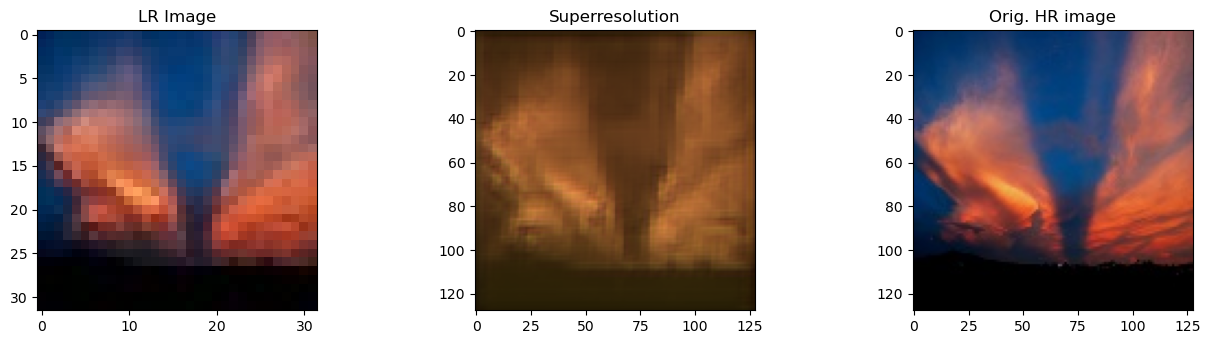

In [42]:
# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [43]:
# Load LR and HR images
test_lr = cv2.imread("test_img32.jpg")
test_hr = cv2.imread("test_img256.jpg")

# Check if the LR image is loaded successfully
if test_lr is not None:
    print("LR image loaded successfully.")
else:
    print("Failed to load LR image.")

# Check if the HR image is loaded successfully
if test_hr is not None:
    print("HR image loaded successfully.")
else:
    print("Failed to load HR image.")

# Change images from BGR to RGB for plotting
test_lr = cv2.cvtColor(test_lr, cv2.COLOR_BGR2RGB)
test_hr = cv2.cvtColor(test_hr, cv2.COLOR_BGR2RGB)

# Normalize pixel values
test_lr = test_lr / 255.
test_hr = test_hr / 255.

# Expand dimensions
test_lr = np.expand_dims(test_lr, axis=0)
test_hr = np.expand_dims(test_hr, axis=0)

# Generate super-resolution image
generated_test_hr = generator.predict(test_lr)


LR image loaded successfully.
HR image loaded successfully.
1/1 [==============================] - 0s 131ms/step


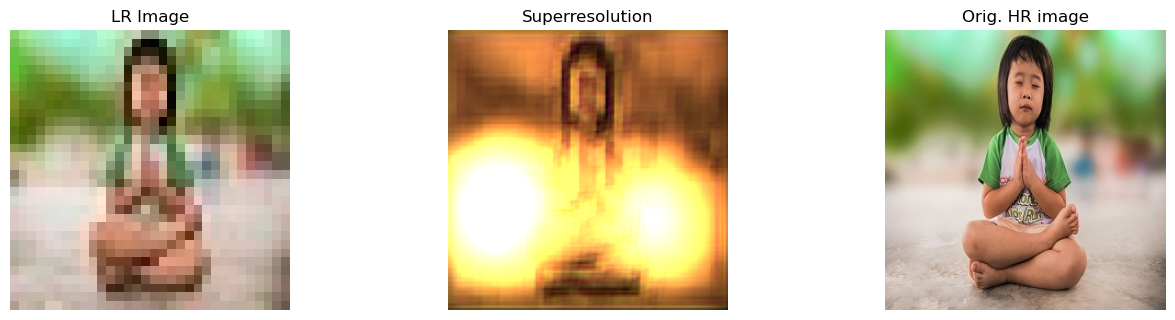

In [44]:
import matplotlib.pyplot as plt

# Plot all three images
plt.figure(figsize=(16, 8))

# LR Image
plt.subplot(231)
plt.title('LR Image')
plt.imshow(test_lr[0,:,:,:].clip(0, 1))  # Clip pixel values to [0, 1] range
plt.axis('off')  # Turn off axis

# Superresolution
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_test_hr[0,:,:,:].clip(0, 1))  # Clip pixel values to [0, 1] range
plt.axis('off')  # Turn off axis

# Original HR image
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(test_hr[0,:,:,:].clip(0, 1))  # Clip pixel values to [0, 1] range
plt.axis('off')  # Turn off axis

plt.show()
